In [28]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_cv

from tensorflow import keras


In [30]:
BATCH_SIZE = 8

IMAGE_SIZE = (256, 256)

CLASSES = {
    0: "turtle",
    1: "penguin",
}

In [31]:
train_directory = "archive/train/train"
test_directory = "archive/valid/valid"

train_paths = sorted(os.path.join(train_directory, file) for file in os.listdir(train_directory))
print(train_paths)
test_paths =  sorted(os.path.join(test_directory, file) for file in os.listdir(test_directory))

['archive/train/train\\image_id_000.jpg', 'archive/train/train\\image_id_001.jpg', 'archive/train/train\\image_id_002.jpg', 'archive/train/train\\image_id_003.jpg', 'archive/train/train\\image_id_004.jpg', 'archive/train/train\\image_id_005.jpg', 'archive/train/train\\image_id_006.jpg', 'archive/train/train\\image_id_007.jpg', 'archive/train/train\\image_id_008.jpg', 'archive/train/train\\image_id_009.jpg', 'archive/train/train\\image_id_010.jpg', 'archive/train/train\\image_id_011.jpg', 'archive/train/train\\image_id_012.jpg', 'archive/train/train\\image_id_013.jpg', 'archive/train/train\\image_id_014.jpg', 'archive/train/train\\image_id_015.jpg', 'archive/train/train\\image_id_016.jpg', 'archive/train/train\\image_id_017.jpg', 'archive/train/train\\image_id_018.jpg', 'archive/train/train\\image_id_019.jpg', 'archive/train/train\\image_id_020.jpg', 'archive/train/train\\image_id_021.jpg', 'archive/train/train\\image_id_022.jpg', 'archive/train/train\\image_id_023.jpg', 'archive/train/

In [32]:
def preprocess_annotations(path):
    df = pd.read_json(path)
    df["category_id"] = df["category_id"].replace(2, 0)
    return df

train_annotations = preprocess_annotations('archive/train_annotations')
test_annotations = preprocess_annotations('archive/valid_annotations')

train_annotations.head()

id  image_id  category_id                  bbox    area segmentation  \
0   0         0            1   [119, 25, 205, 606]  124230           []   
1   1         1            1   [131, 82, 327, 440]  143880           []   
2   2         2            0  [225, 298, 198, 185]   36630           []   
3   3         3            0  [468, 109, 172, 193]   33196           []   
4   4         4            1   [14, 242, 611, 154]   94094           []   

   iscrowd  
0        0  
1        0  
2        0  
3        0  
4        0

In [33]:
resizer = keras_cv.layers.Resizing(
    *IMAGE_SIZE, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

augmenter = keras.Sequential(
    layers=[
        resizer,
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    ]
)

In [34]:
def get_image(path, label, bbox):
    file = tf.io.read_file(path)
    return tf.image.decode_jpeg(file), label, bbox

def to_dict(image, label, bbox):
    # Convert to object detection format expected by Keras CV
    bounding_boxes = {
        "classes": [label],
        "boxes": [bbox],
    }
    return {"images": image, "bounding_boxes": bounding_boxes}
def generate_dataset(image_paths, annotations, augment=False):
    return (
        tf.data.Dataset.from_tensor_slices((
            image_paths,
            annotations["category_id"],
            annotations["bbox"].to_list())
        )
        .map(get_image, num_parallel_calls=tf.data.AUTOTUNE)
        .map(to_dict, num_parallel_calls=tf.data.AUTOTUNE)
        .ragged_batch(BATCH_SIZE)
        .map(lambda b: augmenter(b) if augment else resizer(b), num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE)
    )
    

train_dataset = generate_dataset(train_paths, train_annotations)
test_dataset = generate_dataset(test_paths, test_annotations)

print(train_dataset)
print(test_dataset)

<_PrefetchDataset element_spec={'images': TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), 'bounding_boxes': {'boxes': RaggedTensorSpec(TensorShape([None, None, 4]), tf.float32, 2, tf.int64), 'classes': RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64)}}>
<_PrefetchDataset element_spec={'images': TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), 'bounding_boxes': {'boxes': RaggedTensorSpec(TensorShape([None, None, 4]), tf.float32, 2, tf.int64), 'classes': RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64)}}>


In [35]:
from keras_cv.metrics import BoxCOCOMetrics
import tqdm
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.metrics = BoxCOCOMetrics(
            bounding_box_format="xywh",
            # passing 1e9 ensures we never evaluate until
            # `metrics.result(force=True)` is
            # called.
            evaluate_freq=1e9,
        )
    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in tqdm.tqdm(self.data):
            images, y_true = batch["images"], batch["bounding_boxes"]
            y_pred = self.model.predict(images, verbose=0)
            
            # Doesn't seem to work with ragged tensors :(
            y_pred = keras_cv.bounding_box.to_dense(y_pred, max_boxes=16)
            y_true = keras_cv.bounding_box.to_dense(y_true, max_boxes=16)

            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)
        return logs

In [36]:
from keras.optimizers import SGD

model = keras_cv.models.RetinaNet(
    num_classes=2,
    bounding_box_format="xywh",
    backbone=keras_cv.models.ResNet50Backbone.from_preset(
            "resnet50_imagenet"
    )
)
    
base_lr = 0.005
optimizer = SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)
    
model.compile(
    classification_loss='focal',
    box_loss='smoothl1',
    optimizer=optimizer,
)

In [27]:
EPOCHS = 20


history = model.fit(
    train_dataset.take(1),
    epochs=1,
    validation_data=test_dataset,
    callbacks=[EvaluateCOCOMetricsCallback(test_dataset)]
)


ValueError: in user code:

    File "e:\python3.10\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "e:\python3.10\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "e:\python3.10\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "e:\python3.10\lib\site-packages\keras_cv\models\object_detection\retinanet\retinanet.py", line 463, in train_step
        boxes, classes = self.label_encoder(x, y_for_label_encoder)
    File "e:\python3.10\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\jjy\AppData\Local\Temp\__autograph_generated_filegum_16e5.py", line 48, in tf__call
        result = ag__.converted_call(ag__.ld(self)._encode_sample, (ag__.ld(box_labels), ag__.ld(anchor_boxes), ag__.ld(image_shape)), None, fscope)
    File "C:\Users\jjy\AppData\Local\Temp\__autograph_generated_filevna_49_y.py", line 55, in tf___encode_sample
        box_ids = ag__.converted_call(ag__.ld(ops).arange, (ag__.ld(gt_boxes).shape[1],), dict(dtype=ag__.ld(matched_gt_idx).dtype), fscope)

    ValueError: Exception encountered when calling layer 'retina_net_label_encoder_2' (type RetinaNetLabelEncoder).
    
    in user code:
    
        File "e:\python3.10\lib\site-packages\keras_cv\models\object_detection\retinanet\retinanet_label_encoder.py", line 214, in call  *
            result = self._encode_sample(box_labels, anchor_boxes, image_shape)
        File "e:\python3.10\lib\site-packages\keras_cv\models\object_detection\retinanet\retinanet_label_encoder.py", line 168, in _encode_sample  *
            box_ids = ops.arange(gt_boxes.shape[1], dtype=matched_gt_idx.dtype)
    
        ValueError: None values not supported.
    
    
    Call arguments received by layer 'retina_net_label_encoder_2' (type RetinaNetLabelEncoder):
      • images=tf.Tensor(shape=(None, 640, 640, None), dtype=float32)
      • box_labels={'boxes': 'tf.RaggedTensor(values=tf.RaggedTensor(values=Tensor("RaggedFromVariant/RaggedTensorFromVariant:2", shape=(None,), dtype=float32), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:1", shape=(None,), dtype=int64)), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))', 'classes': 'tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=float32), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))'}


In [37]:
from keras_cv import visualization

dataset_iter = iter(test_dataset)

1/1 [==============================] - 9s 9s/step


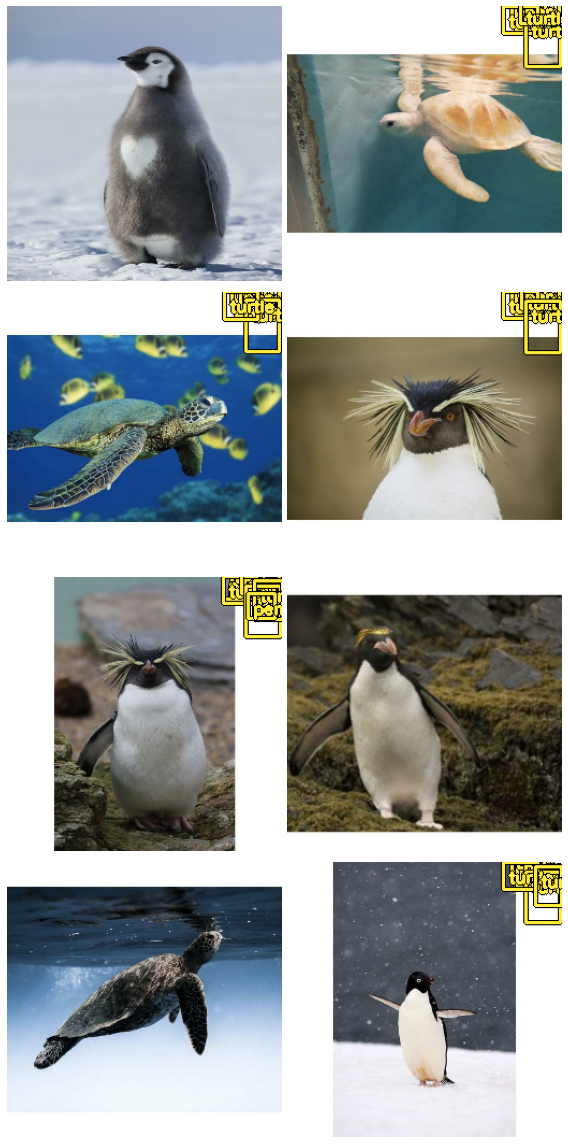

In [38]:
batch = next(dataset_iter)

prediction = model.predict(batch["images"])

# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    batch["images"],
    value_range=(0, 255),
    scale=4,
    cols=2,
    rows=BATCH_SIZE // 2,
    show=True,
    font_scale=0.5,
    y_pred=prediction,
    y_true=batch["bounding_boxes"],
    bounding_box_format="xywh",
    class_mapping=CLASSES,
)